<a href="https://colab.research.google.com/github/ysprem/airbnb-santaclara-analysis/blob/main/airbnb_santaclara_county_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will be looking at Airbnb dataset as part of my Udacity DS Nanodegree project and we will follow the CRISP-DM process to understand the dataset and answer some interesting business questions about the data.

**BUSINESS UNDERSTANDING**





1. **Which city in Santa Clara county has the most Airbnb listings? Which city has the least number of listings? What type of listings are they? (% of private room listings vs % of entire home listings vs % of shared room listings)**
2. **Which city has received the most number of reviews from visitors? Which city has received the least? Which city has the most reviews on average per listing?**
3. **In which month do we see a spike in reviews during the year?**
4. **Which city has the highest average price and lowest average price? Does it change if we look at 
median prices?**
5. **How many hosts have only 1 listing, how many have more than 1 listing?**








**DATA PREPARATION**

Let's load all the relevant libraries first

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from google.colab import drive
from google.colab import data_table

We will use the sqldf function present within the pandasql library. It helps us write SQL queries on pandas dataframes and is extremely convenient for data analysis. Since, it is a non standard package, we will have to install it first. Colab supports installing 3rd party packages using the pip install command. Using '!' before the command lets us write terminal like commands within Colab

In [9]:
!pip install pandasql
from pandasql import sqldf

  Created wheel for pandasql: filename=pandasql-0.7.3-cp37-none-any.whl size=26820 sha256=1b643be1fef1ec65d2979c42110198fe340344028b1b3cd01c628cb7aeaf4a35
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


I uploaded the datasets on to my Google Drive folder so that I can easily load as a dataframe in my Jupyter notebook

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


***Gather the data***



In [3]:
df_listings = pd.read_csv('/content/gdrive/MyDrive/airbnb_santaclara_dataset/listings.csv')
df_calendar = pd.read_csv('/content/gdrive/MyDrive/airbnb_santaclara_dataset/calendar.csv')
df_reviews = pd.read_csv('/content/gdrive/MyDrive/airbnb_santaclara_dataset/reviews.csv')

Now let's take a look at all the datasets to see what columns they contain. We will attempt to answer the 5 questions listed above using this data.

**DATA UNDERSTANDING**

***Assess the data***

In [4]:
df_listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,11464,Deluxe Studio 5 min. to SC Kaiser & Apple Park,42458,Emey,NaN,Santa Clara,37.34342,-121.98829,Entire home/apt,75,4,8,2021-01-17,0.10,17,149
1,21373,Bonsai Garden Inn in Professorville,7054,Mei Lin,NaN,Palo Alto,37.44001,-122.15667,Private room,80,2,264,2020-03-14,2.02,4,226
2,37512,Private room - Parking 3 carport,161741,Maria,NaN,San Jose,37.30598,-121.84036,Private room,48,1,183,2017-03-14,1.42,2,236
3,52786,Cozy Room in A Quiet Community,161741,Maria,NaN,San Jose,37.30521,-121.84149,Private room,50,1,478,2020-03-11,3.80,2,236
4,62799,Zen Office and Sofa in Palo Alto,7054,Mei Lin,NaN,Palo Alto,37.43925,-122.15617,Private room,100,7,148,2020-03-18,1.81,4,225


This is quite a bit of metadata. All listings have a unique id and all hosts have a unique id (host_id). We are also given room type and price. This can help in understanding a little bit more about the listings in each city within the county

In [5]:
df_reviews.head()

,listing_id,date
0,11464,2014-06-15
1,11464,2014-12-13
2,11464,2016-08-21
3,11464,2018-07-28
4,11464,2018-08-26


This dataset contains the review timestamp for each listing id. This can help us perform interesting timeseries analysis on the reviews data.

In [6]:
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,11464,2021-02-21,f,$75.00,$75.00,4.0,1125.0
1,917723,2021-02-22,t,$100.00,$100.00,1.0,15.0
2,917723,2021-02-23,t,$100.00,$100.00,1.0,15.0
3,917723,2021-02-24,t,$100.00,$100.00,1.0,15.0
4,917723,2021-02-25,t,$100.00,$100.00,1.0,15.0


This dataset more or less contains the same info as the listings dataset, just with a little more granularity on availability. We will not use this dataset for this analysis and focus more the above 2 datasets.

Now, that we have a preliminary understanding of the data, let's try to answer some interesting business questions about these datasets.

***Analyse the data***

**Which city in Santa Clara county has the most Airbnb listings? Which city has the least number of listings? What type of listings are they? (% of private room listings vs % of entire home listings vs % of shared room listings)**

First let's look at the number of listings per city.

In [7]:
df_listings.neighbourhood.value_counts()

San Jose                2127
Sunnyvale                556
Santa Clara              554
Palo Alto                537
Mountain View            487
Cupertino                229
Unincorporated Areas     211
Milpitas                 161
Campbell                  94
Los Altos                 67
Los Gatos                 61
Saratoga                  58
Los Altos Hills           34
Morgan Hill               31
Gilroy                    19
Monte Sereno              16
Name: neighbourhood, dtype: int64

San Jose clearly has the most listings (which is expected as San Jose is the most populated city in Santa Clara county. Monte Sereno has the least number of listings as it is the least populated city.

Now, let's see the number of listings per room type

In [8]:
df_listings.room_type.value_counts()

Entire home/apt    2719
Private room       2349
Shared room         171
Hotel room            3
Name: room_type, dtype: int64

There are slightly more listings offering entire home for rent when compared to offering just a private room.


Now let's look at the split of room types in various cities

In [11]:
result1 = sqldf("SELECT neighbourhood, num_listings, entire_home*100/num_listings AS entire_home_percent, private_room*100/num_listings AS private_room_percent, shared_room*100/num_listings AS shared_room_percent FROM (SELECT neighbourhood, COUNT(id) AS num_listings, SUM(CASE WHEN room_type LIKE 'Entire home/apt' THEN 1 ELSE 0 END) AS entire_home, SUM(CASE WHEN room_type LIKE 'Private room' THEN 1 ELSE 0 END) AS private_room, SUM(CASE WHEN room_type LIKE 'Shared room' THEN 1 ELSE 0 END) AS shared_room FROM df_listings GROUP BY neighbourhood)")

We will use the data table extension of Google Colab as it helps us print the tables nicely and even add filters to it to slice and dice data as needed.

In [12]:
data_table.DataTable(result1, include_index=False)

,neighbourhood,num_listings,entire_home_percent,private_room_percent,shared_room_percent
0,Campbell,94,59,38,2
1,Cupertino,229,53,43,3
2,Gilroy,19,10,89,0
3,Los Altos,67,53,40,5
4,Los Altos Hills,34,44,44,11
5,Los Gatos,61,54,45,0
6,Milpitas,161,32,61,5
7,Monte Sereno,16,93,6,0
8,Morgan Hill,31,22,77,0
9,Mountain View,487,69,27,3


After some SQL magic, we can see a nice split of room types of various listings among various cities. Interestingly, Monte Sereno has the highest proportion of listings that rent out the entire home (93% of all listings) whereas Gilroy has the highest proportion of listings that rent out just a private room (89% of all listings).

You can also conclude that Monte Sereno is the most family friendly place for tourists (due to its very high share of entire homes for rent) whereas Gilroy is more suited for single budget/business travelers.

**Which city has received the most number of reviews from visitors? Which city has received the least?  Which city has the most reviews on average per listing?**

Our interest in looking at the volume of reviews is due to the fact that it correlates with the volume of visitors roughly. Another interesting metric is the average reviews per listing as this correlates with user engagement on an average for the city, indicating whether the city has high quality or low quality listings

In [27]:
result2 = sqldf("SELECT neighbourhood, COUNT(id) AS num_listings, SUM(number_of_reviews) AS num_reviews,  SUM(number_of_reviews)/COUNT(id) AS avg_reviews_per_listing FROM df_listings GROUP BY neighbourhood")
data_table.DataTable(result2, include_index=False)

,neighbourhood,num_listings,num_reviews,avg_reviews_per_listing
0,Campbell,94,3160,33
1,Cupertino,229,5205,22
2,Gilroy,19,336,17
3,Los Altos,67,2066,30
4,Los Altos Hills,34,1589,46
5,Los Gatos,61,2432,39
6,Milpitas,161,3189,19
7,Monte Sereno,16,885,55
8,Morgan Hill,31,446,14
9,Mountain View,487,13985,28


***Visualize the data***

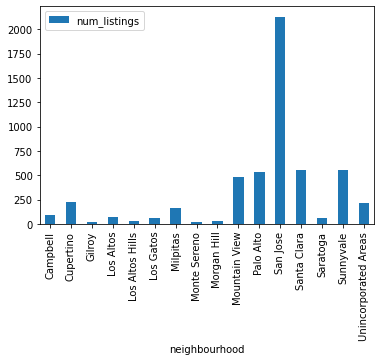

In [28]:
result2.plot.bar(x = 'neighbourhood', y = 'num_listings')

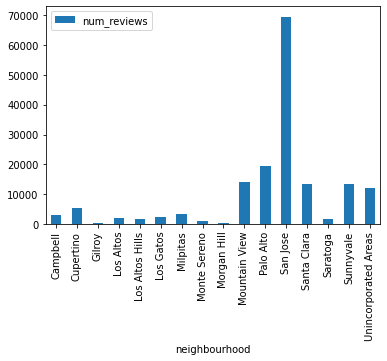

In [29]:
result2.plot.bar(x = 'neighbourhood', y = 'num_reviews')

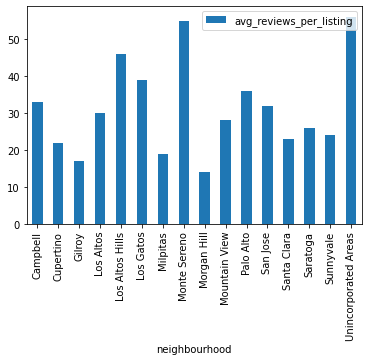

In [30]:
result2.plot.bar(x = 'neighbourhood', y = 'avg_reviews_per_listing')

It is interesting to know that Monte Sereno (and unincorporated areas) punches way above its weight with highest average reviews per listing, which could be mean very interesting or engaging listings. Morgan Hill and Gilroy had the least number of reviews on an average per listing. This could be indicative of relatively staid and conventional listings in these 2 places.

**In which month do we see a spike in reviews during the year?**


This question is interesting as it can help us understand when visitors visit Santa Clara county the most in a given year. To do this analysis, we will be doing a bit of data time transformations

To do that, we will write a function that converts the date string into month and then extracts month name from it.





In [20]:
def date_convert(s):
    '''
    Extracts month name from date string
    INPUT: Date as string in YYYY-MM-DD format
    OUTPUT: Month name extracted from the date as string
    '''
    MONTHS = ['January', 'February', 'Match', 'April', 'May', 'June',
      'July', 'August', 'September', 'October', 'November', 'December']
    y = s[:4]
    m = int(s[5:-3])
    d = s[8:]
    month_name = MONTHS[m - 1]
    return "%s" %(month_name)

In [23]:
df_reviews['month_name']=df_reviews['date'].apply(date_convert)
df_reviews['month'] = pd.DatetimeIndex(df_reviews['date']).month

In [24]:
df_reviews.head()

,listing_id,date,month_name,month
0,11464,2014-06-15,June,6
1,11464,2014-12-13,December,12
2,11464,2016-08-21,August,8
3,11464,2018-07-28,July,7
4,11464,2018-08-26,August,8


Voila! we now know the month during which the review was posted.

In [25]:
result3 = sqldf("SELECT month_name, COUNT(*) AS num_reviews FROM df_reviews GROUP BY month")
data_table.DataTable(result3, include_index=False)

,month_name,num_reviews
0,January,13413
1,February,12893
2,Match,12136
3,April,9497
4,May,13158
5,June,13380
6,July,13095
7,August,15787
8,September,15846
9,October,16706


Now we will seaborn library to plot a timeseries chart of the review volume per month

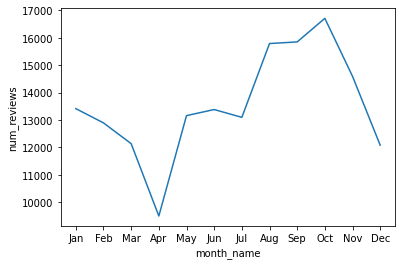

In [ ]:
sns.lineplot(data=result3, x='month_name', y='num_reviews')

It is very interesting to know that Santa Clara country receives most of its tourists around Sept/Oct (taking into account the fact that users might review the listings after their stay, sometimes with a delay). It also receives the least number of visitors in March/April.

**Which city has the highest average price and lowest average price? Does it change if we look at 
median prices?**

This question is all about the listing economics. We will be using some descriptive statistics to identify the average price of listing per city to identify the most expensive and least expensive cities in Santa Clara county. We will also round the values to the nearest integer for ease of comparison

In [ ]:
result4 = df_listings.groupby('neighbourhood').agg({'price': ['mean', 'median','min', 'max']})
result4.round()

price                 
                       mean median min   max
neighbourhood                               
Campbell              169.0  124.0  25  2000
Cupertino             153.0  111.0  24  3157
Gilroy                153.0   65.0  36  1189
Los Altos             198.0  129.0  28  1000
Los Altos Hills       295.0  145.0  40  3998
Los Gatos             180.0  120.0  39  1000
Milpitas              149.0   85.0   0  2222
Monte Sereno          190.0  134.0  98  1000
Morgan Hill            95.0   80.0  45   180
Mountain View         193.0  136.0  24  1200
Palo Alto             224.0  133.0  29  5000
San Jose              137.0   92.0  14  2000
Santa Clara           162.0  100.0  17  3000
Saratoga              274.0   97.0  37  3400
Sunnyvale             122.0   90.0  24  3000
Unincorporated Areas  251.0  110.0   0  5500

Los Altos Hills has the highest average price for listings (which is expected as Los Altos Hills is one of the richest cities in USA) whereas Morgan Hill has the lowest average price. However, when looking at median prices, Gilroy has the lowest median price (Los Altos Hills comes out on top again with highest median prices).

**How many hosts have only 1 listing, how many have more than 1 listing?**

This question, albeit simple looking, as interesting socio-economic implications. A high prevelance of multi listing owners can indicate a larger proportion of population depending on tourism rentals for their income. This can mean a shortage of long term housing for residents.

In [ ]:
result5 = sqldf("SELECT CASE WHEN num_listings_per_host>1 THEN 'multi_listing_owner' ELSE 'single_listing_owner END AS host_type, SUM(num_hosts) AS num_hosts_per_type FROM (SELECT num_listings AS num_listings_per_host, COUNT(host_id) AS num_hosts FROM (SELECT host_id, COUNT(*) AS num_listings FROM df_listings GROUP BY host_id) GROUP BY num_listings_per_host) GROUP BY host_type")
data_table.DataTable(result5, include_index=False)

,host_type,num_hosts_per_type
0,multi_listing_owner,779
1,single_listing_owner,1772


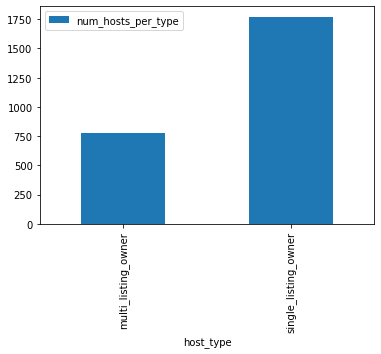

In [ ]:
result5.plot.bar(x = 'host_type', y = 'num_hosts_per_type')

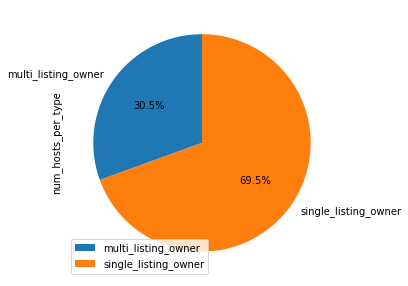

In [ ]:
result5.plot.pie(y = 'num_hosts_per_type', x = 'host_type', figsize=(5,5), autopct='%1.1f%%', startangle=90, labels=result5.host_type)

1772 hosts (69.5% of all hosts) have a single listing whereas 779 hosts (30.5% of all hosts) have more than 1 listing posted on Airbnb. This is an interesting data point. It shows that there are a significant number of hosts (with multiple listings) who rely on Airbnb for their rental income from their properties.

It also reflects the current shortage of affordable long term housing in Santa Clara county